In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import deepmatcher as dm
import pandas as pd
from utils.deepmatcher_utils import wrapDm
import numpy as np

In [4]:
pd.set_option('display.max_colwidth',None)

## Black-box explanation

In [4]:
from utils.triangles_method import explainSamples

In [14]:
DATA_DIR ='../../datasets/Structured/Walmart-Amazon/'
allSamples = pd.read_csv(DATA_DIR+'merged_test.csv')

In [6]:
hybrid = dm.MatchingModel(attr_summarizer='hybrid')
hybrid.load_state('../../models/walmartamazon_hybrid.pth')
hybrid = hybrid.to('cuda')

In [7]:
rnn = dm.MatchingModel(attr_summarizer='rnn')
rnn.load_state('../../models/walmartamazon_rnn.pth')
rnn = rnn.to('cuda')

In [15]:
prediction = wrapDm(allSamples,rnn,ignore_columns=['label'])
correct_preds = allSamples[np.argmax(prediction,axis=1)==allSamples.label.values]
len(allSamples),len(correct_preds)

(2049, 1911)

In [19]:
prediction4hybrid = wrapDm(allSamples,hybrid,ignore_columns=['label'])
correct_preds4hybrid = allSamples[np.argmax(prediction4hybrid,axis=1)==allSamples.label.values]
len(allSamples),len(correct_preds4hybrid)

(2049, 1919)

In [11]:
walmart = pd.read_csv(DATA_DIR+'tableA.csv',dtype=str)
amazon = pd.read_csv(DATA_DIR+'tableB.csv',dtype=str)

In [17]:
neg_ranking,flippedneg = explainSamples(correct_preds,[walmart,amazon],rnn,wrapDm,
                                       class_to_explain=0,maxLenAttributeSet=3)

100%|██████████| 122/122 [00:50<00:00,  2.43it/s]


In [20]:
neg_ranking4hybrid,flippedneg4hybrid = explainSamples(correct_preds4hybrid,[walmart,amazon],hybrid,wrapDm,
                                       class_to_explain=0,maxLenAttributeSet=3)

100%|██████████| 134/134 [01:03<00:00,  2.11it/s]


In [22]:
pos_ranking,flippedpos = explainSamples(correct_preds,[walmart,amazon],rnn,wrapDm,
                                       class_to_explain=1,maxLenAttributeSet=1)

100%|██████████| 122/122 [00:35<00:00,  3.45it/s]


In [22]:
flippedneg.to_csv('rnn_flippedneg.csv',index=False)

In [14]:
flippedpos.to_csv('rnn_flippedpos.csv',index=False)

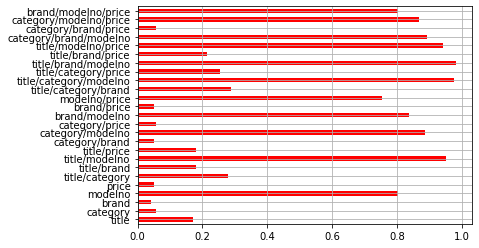

In [23]:
neg_ranking.plot.barh(color='red',grid=True).get_figure().savefig('rnn_neg_ranking.png')

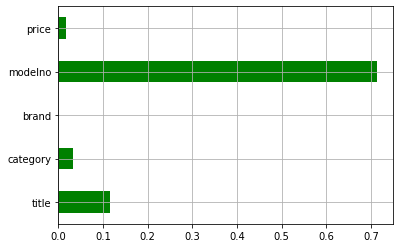

In [24]:
pos_ranking.plot.barh(color='green',grid=True).get_figure().savefig('rnn_pos_ranking.png')

## Patterns extraction

In [60]:
import ast
from utils.patternDiscovery import getMaxFrequentPatterns

In [55]:
flippedneg = pd.read_csv('rnn_flippedneg.csv')
flippedpos = pd.read_csv('rnn_flippedpos.csv')

In [24]:
flippedneg['alteredAttributes'] = flippedneg['alteredAttributes'].apply(lambda t:ast.literal_eval(t))
flippedpos['alteredAttributes'] = flippedpos['alteredAttributes'].apply(lambda t:ast.literal_eval(t))

In [36]:
neg_pattern_on_title = getMaxFrequentPatterns(flippedpos[flippedpos.alteredAttributes==('title',)],
                                             ['ltable_title','rtable_title'])

In [44]:
neg_pattern_on_title.head(10)

,support,itemsets
0,0.201754,"(L_rear, R_x, R_projection, L_screen, R_screen, L_x, L_projection, R_rear, R_format, L_format)"
1,0.205742,(L_video)
2,0.212919,"(R_-, R_x, L_screen, R_screen, L_x, R_format, L_format)"
3,0.242424,(L_black)
4,0.200159,"(R_-, L_-, R_x)"
5,0.210526,"(L_x, L_-, R_x)"


In [49]:
pos_pattern_on_title = getMaxFrequentPatterns(flippedneg[flippedneg.alteredAttributes==('title',)],
                                             ['ltable_title','rtable_title'])
pos_pattern_on_title.head(10)

,support,itemsets
0,0.202142,(L_screen)
1,0.220884,"(L_x, R_x)"
2,0.224900,(L_black)
3,0.433735,(L_-)


## Test pattern influence

In [8]:
test_df = pd.read_csv(DATA_DIR+'merged_test.csv')
positives = test_df[test_df.label==1].copy()
len(positives)

193

In [10]:
predictions = wrapDm(positives,rnn,['label'])
np.count_nonzero(np.argmax(predictions,axis=1)==1)

130

In [18]:
positives = test_df[test_df.label==1].copy()
positives['ltable_title'] =  positives['ltable_title']+ " thru-the-wall tensioned"
positives['rtable_title'] =  positives['rtable_title']+ " thru-the-wall tensioned"

In [19]:
predictions = wrapDm(positives,rnn,['label'])
np.count_nonzero(np.argmax(predictions,axis=1)==1)

131

In [20]:
predictions = wrapDm(positives,hybrid,['label'])
np.count_nonzero(np.argmax(predictions,axis=1)==1)

132

In [ ]:
s = "rear projection screen x format"